# Walking using the Linear Inverted Pendulum Model

In this exercise, we will use the linear inverted pendulum model (LIPM) seen in class as a model for bipedal walking and we will derive a model predictive control law that will stabilize walking in face of external disturbances.

The LIPM can be derived from the (complicated) dynamics of any legged robot. It describes the dynamics of the Center of Mass (CoM) of the robot when we assume that the CoM height is constant and that the angular momentum at the CoM is 0.

<img src="lipm.png" alt="missing LIPM figure" width="400"/>

In this case, the motion of the CoM in the horizontal plane (forward and side motions) can be written as a linear dynamical system. In particular, the forward and side motions are decoupled. In the following, we will only consider forward motions and ignore side movement. The forward motion of the CoM, using this model, can be written
$$\begin{align}\dot{x} &= v \\ \dot{v} &= \omega(x - u)\end{align}$$
where $x$ is the CoM position, $v$ its velocity, $\omega = \frac{g}{z}$, $z$ is the CoM height, $g$ the gravity constant and $u$ is the center of pressure (CoP) location on the ground.

We know that, to be physically consistent, the CoP needs to be located inside the support polygon formed by the feet on the ground. In the case where one foot is on the ground, the CoP needs to be inside the foot.

Since the differential equation is linear, we can explicitly solve it for a given $\Delta t$ assuming a constant center of pressure during that time. We then get the following linear discrete system
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$

The idea is to find CoP locations (which will then be realized by an another controller on the real robot) such that we can move the CoM where we want and such that the CoP is always inside the support polygon. We will assume that there is only one leg touching the ground at a time. Assuming that the foot on the ground is located at time $n$ at $f_n$ and that the foot has a length of $l_{foot}$, the CoP constraint reads
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$
We will also assume that we predefine the foot step locations in advance.

We now have almost all the ingredients necessary to construct an optimal control problem. We just need a cost function. Here, to keep the problem simple, we will assume that during walking, we try to keep the CoM above the foot in contact as much as possible and that we try to keep the CoP at the center of the foot as much as possible. We will also try to keep the velocity of the CoM as small as possible. We therefore have the following optimal control problem
$$\min_{u_n} \sum_{n=0}^{N-1} \left( \begin{matrix} x_n - f_n \\ v_n \end{matrix} \right) ^T Q \left(\begin{matrix} x_n - f_n \\ v_n \end{matrix}\right) + (u_n - f_n)^T R (u_n - f_n) + \left( \begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)^T Q_N \left(\begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)$$
subject to
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$
and
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$

In [12]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

import cvxopt

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

## Solving a constrained linear optimal control problem

We provide the function below to solve LQ optimal control problems with constraints as we have seen in class. We will use this solver to construct a model predictive controller for walking. The function solves problems of the form
$$\min_{u_n} \sum_{n=0}^{N-1} x_n^T Q_n x_n + q_n^T x_n + u_n^T R_n u_n + r_n^T u_n$$
subject to
$$x_{n+1} = A x_n + B u_n,\qquad x_0 = x(0)$$
and
$$G_n \begin{bmatrix}x_n \\ u_n \end{bmatrix} \leq h_n$$
where the dynamics is independent of $n$ and the costs and bounds can change at every time step.

In [13]:
def solve_mpc_collocation(A,B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0):
    """
    Here we want to do MPC with a collocation approach
    we assume that A and B are constant but Q, q, R, r and the bounds are given as list of vectors/matrices
    one per time step
    
    it returns a state trajectory and a control trajectory
    """
    # the number of states we will need to optimize for
    num_states = x0.size*horizon_length
    u_size = B.shape[1]
    # the number of control to optimize
    num_control = u_size*horizon_length
    # the total number of variables we need to optimize
    num_vars = num_states + num_control

    # the total Hessian of the problem (the quadratic part) [x u]^T Qtot [x u]
    Qtilde = np.zeros([num_vars, num_vars])
    # the total linear part
    qtilde = np.zeros([num_vars, 1])
    
    Atilde = np.zeros([num_states, num_vars])
    btilde = np.zeros([num_states])
    # we impose the initial condition x0
    btilde[0:x0.size] = -A.dot(x0)
    
    G_tilde = None
    h_tilde = None


    for i in range(horizon_length):
        # we put Q and R in the right places on the diagonal
        Qtilde[x0.size*i:x0.size*(i+1), x0.size*i:x0.size*(i+1)] = Q[i]
        Qtilde[num_states+u_size*i:num_states+u_size*(i+1), num_states+u_size*i:num_states+u_size*(i+1)] = R[i]
       
        # same for q and r
        qtilde[i*x0.size:(i+1)*x0.size] = q[i]
        qtilde[num_states+i*u_size:num_states+(i+1)*u_size] = r[i]
    
        # we construct the equality constraint for the dynamics
        Atilde[x0.size*i:x0.size*(i+1),num_states+u_size*i:num_states+u_size*(i+1)] = B
        if i>0:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i-1):x0.size*(i+1)] = np.hstack((A, -np.eye(x0.size)))
        else:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i):x0.size*(i+1)] = -np.eye(x0.size)
        
        # now we construct the inequalities Gtilde [x u] <= htild
        G_tmp = np.zeros([G_bounds[i].shape[0], num_vars])
        G_tmp[:, x0.size*i:x0.size*(i+1)] = G_bounds[i][:,:x0.size]
        G_tmp[:, num_states+u_size*i:num_states+u_size*(i+1)] = G_bounds[i][:,x0.size:]
        if G_tilde is None:
            G_tilde = G_tmp
        else:
            G_tilde = np.vstack((G_tilde, G_tmp))

        if h_tilde is None:
            h_tilde = h_bounds[i]
        else:
            h_tilde = np.vstack((h_tilde, h_bounds[i]))
        
            
    # we transform our data into cvxopt complicant data
    Qtot = cvxopt.matrix(Qtilde)
    p = cvxopt.matrix(qtilde)
    
    G = cvxopt.matrix(G_tilde)
    h = cvxopt.matrix(h_tilde.flatten())
    
    Atilde = cvxopt.matrix(Atilde)
    btilde = cvxopt.matrix(btilde)
    
    #now we call cvxopt to solve the quadratic program constructed above
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(Qtot,p,G,h,Atilde, btilde)
    x = np.array(sol['x'])
    u = x[num_states:]
    x = x[0:num_states]

    return  np.vstack((x0, x.reshape([horizon_length, x0.size]))).T, u.T

## Simulation of the LIPM

In [14]:
class LIPM:
    """
    This class implements a linear inverted pendulum model - we will use it to simulate the walking robot
    """
    
    def __init__(self):
        """
        constructor of the class
        """        
        #gravity constant
        self.g=9.81
        
        #CoM height
        self.z_com = 1.0

        #integration step (100ms)
        self.dt = 0.1
        
        #
        self.omega = np.sqrt(self.g / self.z_com)
        
        #the transition matrices
        self.A = np.array([[np.cosh(self.dt*self.omega), 1./self.omega * np.sinh(self.dt*self.omega)],
                          [self.omega * np.sinh(self.dt*self.omega), np.cosh(self.dt*self.omega)]])
        self.B = np.array([[1 - np.cosh(self.dt*self.omega)],[-self.omega * np.sinh(self.dt*self.omega)]])
        
        # half of the size of the foot (i.e. the foot is 30cm long)
        self.foot_size = 0.15        
                        
    def next_state(self,x,u):
        """
        Inputs:
        x: state of the system as a numpy array (x,v)
        u: cop position as a scalar
        
        Output:
        the new state as a numpy array
        """
        
        return self.A.dot(x) + self.B.dot(u)
        
    
    def simulate(self, x0, controller, horizon_length, foot_steps, noise=True):
        """
        This function simulates the LIPM for horizon_length steps from initial state x0
        
        Inputs:
        x0: the initial conditions as a numpy array (x,v)
        controller: a function that takes a state x as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        foot_steps: an array containing foot step locations for every time step (this is used to ensure u is constrained to the support polygon)
        
        Output:
        x[2xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = np.clip(controller(x[:,i],i), foot_steps[i]-self.foot_size, foot_steps[i]+self.foot_size)
            x[:,i+1] = self.next_state(x[:,i], u[:,i])
            if i>0 and noise:
                disturbance = np.random.normal(0., 0.01)
                x[1,i+1] += disturbance
        return x, u

## Animation and plotting utility

In [15]:
def animate_walker(plotx, plotu, foot_pose):
    """
    This function makes an animation showing the behavior of the LIPM with some graphics showing the CoP, etc.
    takes as input the result of a simulation (with dt=0.1s), the CoP position (plotu) and the foot step locations fn (foot_pose)
    """
    use_dt = 100
    
    feet_colors = ['b','g']
    c_foot_c = 0
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-0.2,9], ylim=[-.2,2.3])
    ax.grid()
    
    list_of_lines = []
    
    #plot the ground
    ax.plot([-0.1,8],  [0,0])
    
    #create the walker
    line, = ax.plot([], [], feet_colors[c_foot_c], lw=2)
    list_of_lines.append(line)
    #for the CoP
    line, = ax.plot([], [], 'or', ms=8)
    list_of_lines.append(line)
    #for the CoM
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the torso
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    #for the head
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the foot
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    com_height = 1.
    torso_height = 1.
    
    def animate(i):
        nonlocal c_foot_c
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        if i>0:
            if foot_pose[i] != foot_pose[i-1]:
                c_foot_c = (c_foot_c + 1)%2
                list_of_lines[0].set_color(feet_colors[c_foot_c])
                                        
        list_of_lines[0].set_data([foot_pose[i], plotx[0,i]], [0, com_height])
        list_of_lines[1].set_data([plotu[0,i], plotu[0,i]], [0, 0])
        list_of_lines[2].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height])
        list_of_lines[3].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height+torso_height])
        list_of_lines[4].set_data([plotx[0,i], plotx[0,i]], [com_height+torso_height, com_height+torso_height])
        list_of_lines[5].set_data([foot_pose[i]-0.15, foot_pose[i]+0.15], [0, 0])
        
        return list_of_lines
    
    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:-1])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [16]:
def plot_results(x_real, u_real, x_plan, u_plan):
    """ this function plots the results of the simulations"""
    
    time = np.linspace(0,horizon_length*walking_model.dt, len(x_real[0,:]))
    plt.figure(figsize=[8,5])
    # plt.subplot(3,1,1)
    plt.plot(time, x_real[0,:], linewidth=6, label='Simulated CoM')
    plt.plot(time, x_plan[0,:], '--', linewidth=6, label='Planned CoM')
    plt.ylim([-1,10])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM position')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[1,:], linewidth=6, label='Simulated CoM Vel')
    plt.plot(time, x_plan[1,:], '--', linewidth=6, label='Planned CoM Vel')
    plt.ylim([-1,2])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM velocity')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time[:-1], u_plan[0,:] - foot_position, linewidth=6, label='Planned CoP in foot')
    plt.plot(time[:-1], u_real[0,:] - foot_position, '--', linewidth=6, label='Simulated CoP in foot')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) + walking_model.foot_size, 'k--', label='upper foot limit')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) - walking_model.foot_size, 'k--', label='lower foot limit')
    plt.xlabel('Time [s]')
    plt.ylabel('CoP position and limits')
    plt.legend()
    
    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[0,:], linewidth=6, label='CoM')
    plt.plot(time[:-1], u_real[0,:], linewidth=6, label='CoP')
    plt.plot(time[:-1], foot_position, 'k', label='foot position')
    plt.plot(time[:-1], foot_position + walking_model.foot_size, 'k--', label='foot boundary')
    plt.plot(time[:-1], foot_position - walking_model.foot_size, 'k--', label='foot boundary')
    plt.xlabel('Time [s]')
    plt.ylabel('Complete simulated pattern')
    plt.legend()

# Planning a walking trajectory 
We can plan a walking trajectory by solving the OC problem above as follows

We are able to compute a plan but when the simulation has noise (e.g. the robot gets pushed or we need to account for errors coming from the simplification of the LIPM vs. the real robot), the plan cannot get the robot to walk. This is shown below.

## Questions

a) Using the example above and the OC solver, write a model predictive controller that re-computes the optimal control at every instant of time as a function of the current state x. The idea is to solve the original OC problem for a shorter horizon and apply only the first control and repeast at every iteration.

b) What is the shortest time horizon that you can use in the MPC controller while still getting a stable walking in a noisy environment? (the simulation is stochastic so you may want to test your algorithm several times to get an "average" behavior). 

c) Relate this horizon time to the duration of one step. How many steps in advance is it necessary to plan for to get a stable controller?

d) How different is the executed control compared to the originally planned one?

e) What happens if you change the weights in the cost function? What if you increase the terminal cost (e.g. to $10^9$)? Can you decrease or increase the receding horizon length? Describe qualitatively the behavior you observe.

In [19]:
#  created a walking model0 for x_plan and u_plan and named them as x_plan0 and u_plan0 later used for plotting
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(round(step_time / walking_model.dt))

# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))

# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan0, u_plan0 = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)

<IPython.core.display.Javascript object>


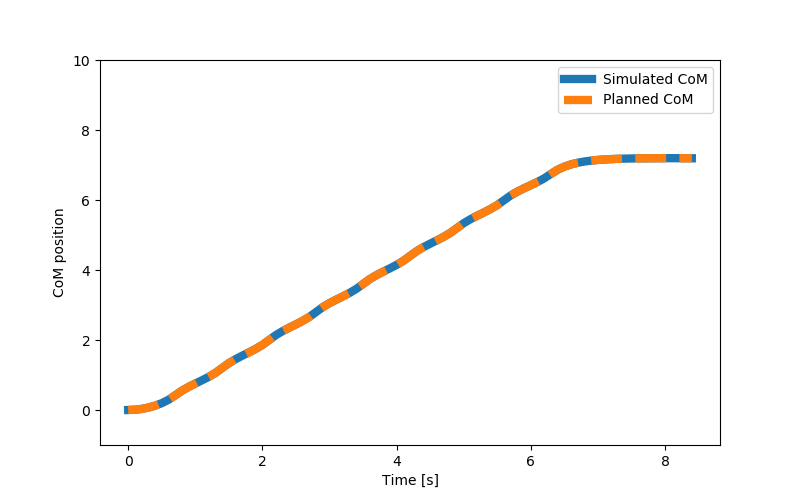

<IPython.core.display.Javascript object>


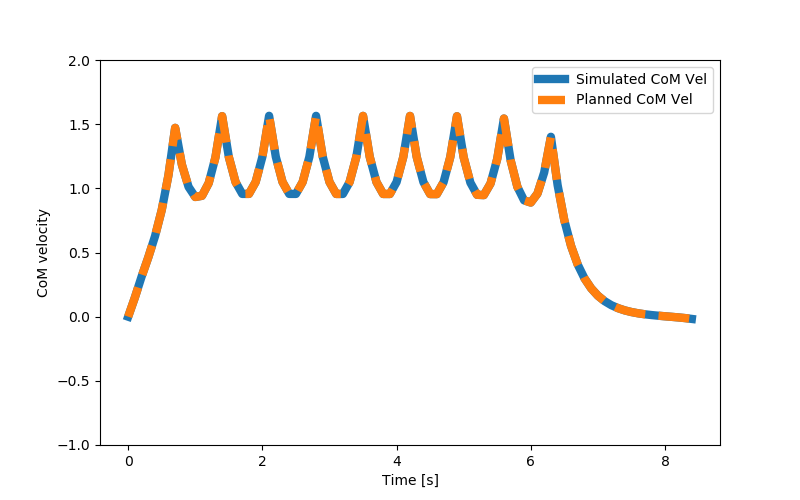

<IPython.core.display.Javascript object>


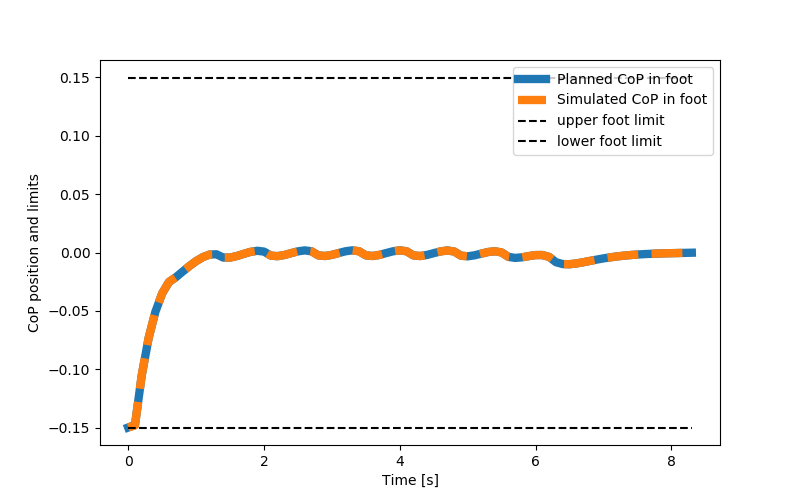

<IPython.core.display.Javascript object>


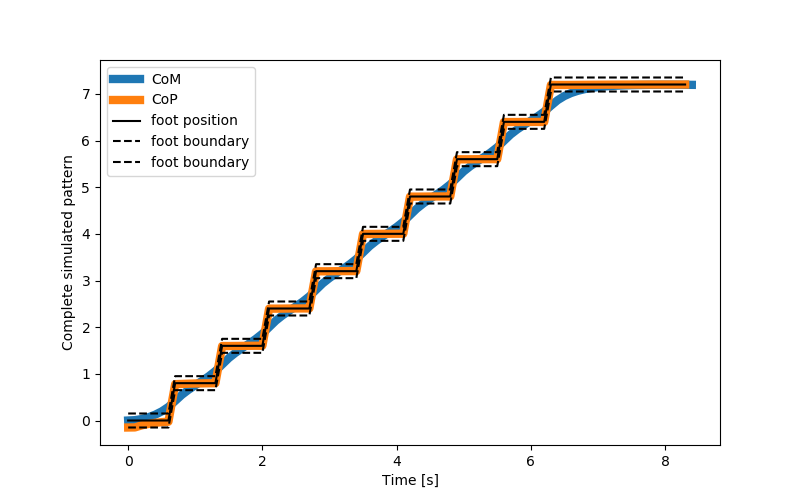

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAYxdtZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADJZliIQAEP/+94G/Mstf
IrrJcfnnfSyszzzkPHJdia640AAAAwAAAwAAAwAGIxI3/ong/hHiVxATyRhZBPrLcoK6KddW3zef
0fRLTWZvO0dBWZK9rj+9cCre32nYZ4GT63obUgA+dZjzrP+J6eae/LDqDtWh+9wdy05ty1qAIR2T
jV06N0HHBMy/eCKEF5M7Zm9AVbA7WBVgdZ7Rxw3nRAVhrv2+fXJZcPQViMoBqGNko/bptPaK34LK
diRS4eLaBixHBiVJU7/5lAh9D7gL5cgWOmEBluY5x3C7bDBp/5ByUTYhRWTsgIPMmREXptOeFVN4
aFlpUzm3W2nvpB5jC1n1rbVTog0NqJ9vtuaCWwve3R1jnIyzYodFGLxFcQpZwpoyfMbVUP78BTo5
goBO8qOEBeowsxuInNaJlMYUxEXCCgM1t5FuZ2fDDabFZo5fX+TkdPodAU2VB3XKf+jBjj+JgWB0
awQEK6Oq19TMEy9b51Tn3yzoyBgjta82yY9xqSo5U37q243NCV0WwRd3zNDcOO2MhC55IHH4CHEX
rqjWUZ9DVKXzPGEmOfnn5VrVbo1a+NcvMopS4RQSCS4+ub6hU2xV7mTEIuMhFGcLdLY269Jgy2z9
o0jsCTtP4HP4OzrSqIC8XgveBFdAl4Jxn3lofW9smKrhLum0aeSfpV/B5+CY8T62JyejC5X9mkV9
FL4GZb8G247x9xpmnznvvmSc4EpdUd2I0OYGsm8WQUGzfo/zXdU6HhH1PQbJOmux7UQnSdPW8eTL
RnMnphYLPAl7w/XVXAzauJpguNz6QT2VOBvmoxjyHjnl4ZnUIeemxjGMhIIujqyoL0q+MX18fNML
XGx7KH8ShrJTYLWW8MTWwvF8BTb365fvkonfXeNM8GkjznanWoDWd7lRBWrx0W62HbyaQfOmDAz6
ocRPZGNQ1nk0vX5EWZAP5LQLSSdhv81HZl8ZnBEU827bXcCkDMm0R+eEeCqmBLWKeW70eOUYEFjZ
tvBSZabzn4G2u/UHfwWLZZZeoBYw3KUTo5yY+QnFyYZRVwa7smv/BBJDWdon/B5/N63ziHYHKCZV
HreC6BuN34OmiHNEw16rzGmkD11R5W6ApADpBj35cVX36WY1muy8prCTUGlLTE5zPWHHFt+pZMPs
zMPgVfLZXHlVLgOgP4rKk5StJK+HpYmaFtGXHacGZ21xCk84WdecxSwrb5uGjHBN9LkkdJhsEHft
TBme5SBt5nyJR83wsuihRjKVAIwb0cpOkpRCyLmOpMntfKmaAomEUkLf9/4J46Pj+N3Hp5/MQ0RT
G+0eB81rYNF3Ddl+y1XWg+x+pbfg+5Dw1S7vvOfDytlzjME8mS0qqzDAw/9/MWSC05WhfkmRCD32
LeSqYcwixFqgpp/bAyngYOW+tfub1Js+SGwxPy+CHv+K3HVVNEDWGdzMCpZN4CZVMeYcv9o7CbkU
XyVs7aPwUs9ta7nU5sFxH4Qe65c9UTqTTJ9cqm4Za1K3Sbn2PJzcODpFBMNXtxwxogGOoVIKVnRV
crEbCtJsZ1XLi2ZVeJLeOYZ3Vg07zCVhicKV1w1KL4l9bJBUApVSGvo3fYHq2a+isbkGDl1JSkC6
xHIsup/NYK2WlwuR1w/yPHOsfSjN/rMHzdcWv+UQJxKSN/+FqpBt/Mgncxassm+sir6JlKlfLX7w
z/Y/2bvHGUOPL5Qt50h8klLBY05+r/m7swvxzojkgAC3yc3+Ap35nKT+oNCuJnnLP0HK87XlZ1RD
HSg/o3vwVSREaqBge9+UlEwVappAbudxG2PhDDPe+yoLo4ebxHoaMEPnzq5XdCCT4N60HbK/iYyM
Zl/kPveouMEysegTfNUk+A9nuvSMiDguL5hMXvwZbIUiTKTtBmaMvqmqMQdZV+7+Xk2niPqUkFdq
UjREl1Ic4f4uVXA1A6Yy9zaLvZzfHZnzni927k9hm0gJS9X9tfgsNbl0H1mlD+8a9PprPq3zgNcP
N0nQNmBSkBeO1zx+/VhrfLPweuYjjq22ESKuG+taGYr78ZD4gqc95GhWDi0A9eQQDhBI61Qs95G3
dQFuY1irHVED+JOJLe8luMTl3zNEFsjxXnscWSWsfh57EehvsgMyFHJjsmugbbEcSmAqNcR7en1R
yVCF8p1eURgTFEDHX33qJ884szXiGozNiZmuBajRKtzMgNKJdf+xigzLovaekEKVXAmqmsf6x82e
aySEL6oR4W8cAwYBwTwSCILZNqCzgeMalKzpGyDtPvN/G/aWYGjz7TR1KkpPl+8lpreVfeBZhRDi
q5gG1AkSJ7jzk0csHscwvsjZD9bZXCkQw1TvtwesQLhLpDvWFRCgtmWNKKu4/fRNx0tT/UH0pvYu
SgtRAgH1cVnTVqVy59azlbaCuMJYOld2YAJ5vN1q2YEBUAdkWAKdgY6TUxr37ugPab+cpH7tPNik
hWLlm/+NT8+iD3aL//ytGfem28PHqMZkq10MuWEz+WtVvbSoARb6P//Xy+/ziXwI5pl+Eihp0z7h
r4bYrbHzH0zh3dYOL2Bff0+qYOqXkBAyhNjZeG6uHx1YSL9oLi9p7GorFesB1lAHCIAuFwum2hPT
qrMa1qpjm27ACSguQREnZD+zn4GB2qqhWdtlwAiCRA/qpGmlfRmxl0XULEY8sGBVEp6giuS26aen
GEN+tC+UsfUMP5b6rMCgtJAfDknw7uau+Kx0QDpl1xGQksSpr5W275HLkZTuYaZ39+E8kySFFsjO
KhZ4GSJy9/czUCk9c7T6b+w6Sfmjuknd5yIfAKOSCljJeWE9zCG/qZHdWOT2i+DwvJc2NxilzVOW
27fWBh36oTaSY07iSK6fFM1NJSMlGQpVK19ITZcTEza8lJ+RqcAJuuv7DgaiP0l1IOAq3fOGL7Kh
CjPQ2JjHbYMyZGHuB6PCL

In [20]:
#Part A
#Applied model predicitive control
#Named the model walking_model1
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(round(step_time / walking_model.dt))

#states for model predicitive control
x_model = np.empty([2, horizon_length+1])
x_model[:,0] = x0

#controls for model predictive control
u_model=np.empty([1,horizon_length])
# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))
###
#####
########
#MODEL PREDICTIVE CONTROL
    
for i in range(horizon_length):
    Qnew = Q[i:]
    qnew = q[i:]
    Rnew = R[i:]
    rnew = r[i:]
    G_bounds_new = G_bounds[i:]
    h_bounds_new = h_bounds[i:]
    foot_position_new = foot_position[i:]
    horizon_length_new = horizon_length - i
        
    x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Qnew,
                                             qnew,Rnew,rnew,G_bounds_new, h_bounds_new, horizon_length_new, x0)
    feedforward_controller = lambda x,i: u_plan[0,i]
    x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length_new, foot_position_new, noise=True)
    x0 = x_real[:,1]
    u_model[:,i] = u_real[:,0]
    x_model[:,i+1] = x0
plot_results(x_model, u_model, x_plan0, u_plan0)
animate_walker(x_model, u_model, foot_position)

<IPython.core.display.Javascript object>


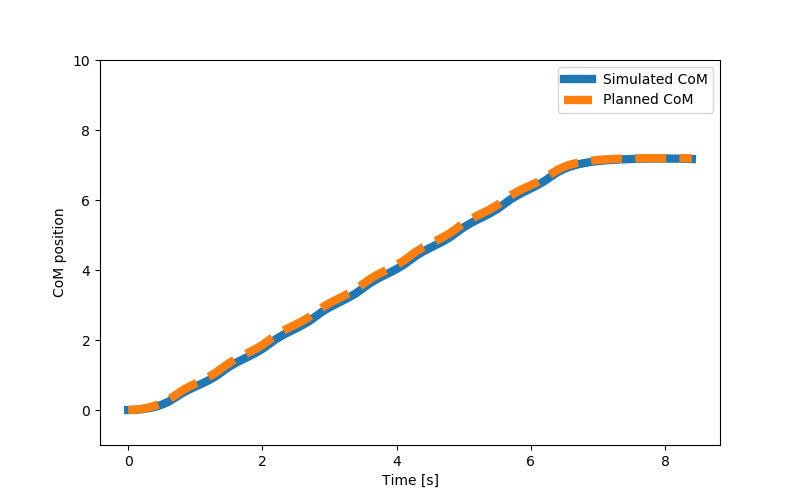

<IPython.core.display.Javascript object>


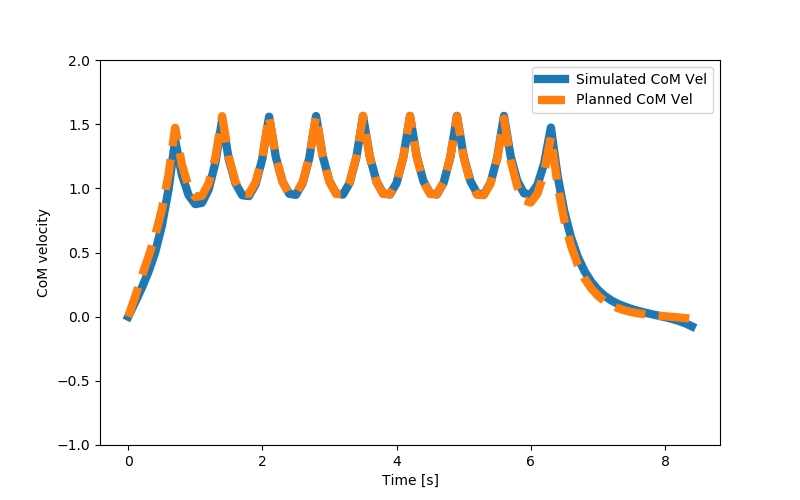

<IPython.core.display.Javascript object>


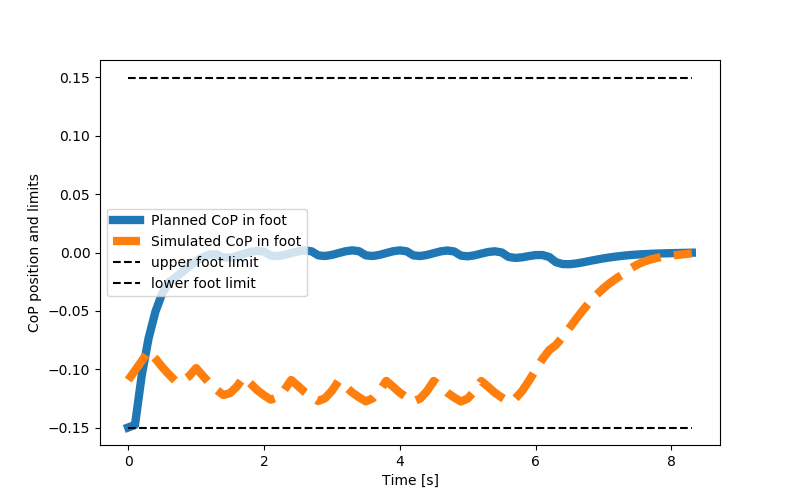

<IPython.core.display.Javascript object>


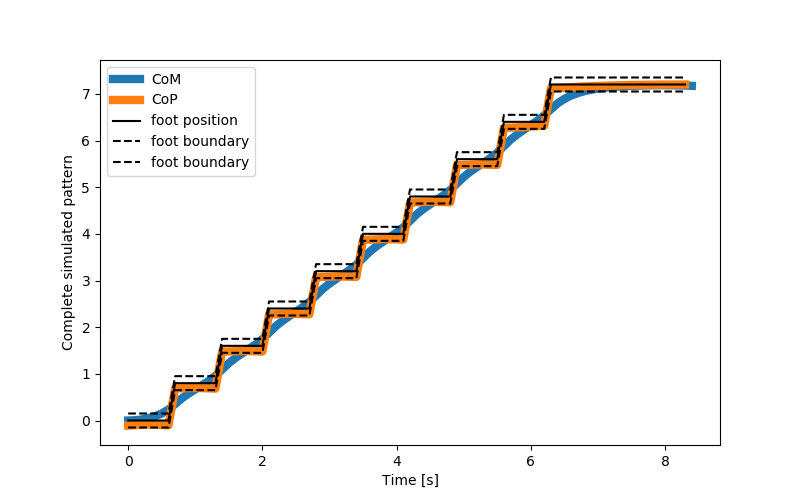

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAZDNtZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADG1liIQAP//+92ifApta
Q3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAADAAB1oWGAKaHP4R4lcQHw3p8gnsmuEhX4031cd/7I
rod6Ryww2Ogq+9e1xtldqQff7T8tEDJB70M96AfOtAd2Gy9DhMHlVY1SVrOLanMctObctagCEbk4
u4BjdBxwTMq8AihBeS6vxvQFWwO1WVYHYrv6ZG86ICsNd+3z648sSeZ6Av9jAxslHynmzh3wCM+v
Sm6W1YdCAsB8d7SVO/+ZQIfQ+4DAXIFjphAZbmOcdwu2wwxf+QclE2IUVk7ICDwpkRF6bTndOjuN
oCA231YWhD30g8xhaz7Ntqp0P2HlvzESp8XJ4XvZo6xzklPKU6/qcolaId6U7M3w4ae8+Ap0ciVc
cDhgQjJJ4L12FTKb2WB+yYFr/c9GtIlK3M7PhhtNis0TBxCbQzKN93kdWOY/KTcdkRnGGgWB0awQ
EK6Oq19TMBzlb51Tn3yzoyBgjtI9CyY9xqSo5U37qw43NCV0WwRd3zNDW0uQ3RJXbRmha9Q94Dxv
ZpTEsWW6Nkzf7Ec77HPhqt0atfHn/8h2cuVtrBtwR9S05trhMjoqRYs2iGH1nY+eW6qbmQVRQbS2
I7vnG+oMFWc6xKqWV4czcLnke3Tv9L3XpVq4nvFwl3TaNPDJLt/BKDqb/07D85OSwKrZ7SbAj3ci
kLK8f4Er8ibrG0DcwUCOU5zqoMRgByH3qe1foer80aGWB0djSgf/U//a07ZivcBRJEYC7yfr7ruN
xrQFxaHhsjhTK6UF/r4GhIFdIkuJX1p+EWc+jyaKOQ6koz7Vdlp8veljjfEKpwCPjvEDQY6llpf5
b4Q2QV43hU8EvLHx6I4ldm1Lh2qCc2klETq55TJ16dWTr28/03DhdxMOu/XPnrUCMdoN0EZJ0GhN
Q1nkY63+RFmQDGL3OFv/y+qwczzAgAABnEHjjM5Qxcu4R4KqYEtYp5bvR4y9JwWNm28FJlpvNqnD
LShhfB0uPgxl6gFjDcpROjnMDUDviQ6cBu3g7Yn/vqrtaztE/4PP5vW+cQ66thTyo9bwXQNxu/Br
UQ5omGvVeY00getzhT7WFIAdIMe/Liq+i0Cys12XlND2giwxtpgIlmPk4yMSIr+gqsRAhQeNQ48q
pcB0B/FXbtKVpJXw9LERDFoy47TgzO2uISFnCzrzmKWFbfNwffgd3yeSR7N8QEBsdy9hdLxBbRb1
VGag8x/OGPo0e7vlevmwNqUohZFuXNsgi0LAQUTEtM2NVwK+neMcrSzLxKpIsE/2ROzcf0nXPru2
KR9JdcKP2mCAI3XkQOnTSq3+I05mTsn6ctk2GRD8xo+OXMEBrA/+hsFiGRP8mC99pMi4Yi/MuWHQ
0TJHkOHXHZtf/DujNueKDGXgFzYYn5fBDLrOu3YeSu+KZexvRBqG10ncTRalESf47YW/nXIEgXt/
cbkRCmtaiyoqjX8o2yLiC2KoUsycQbfZlbiZH4zLCtrmUCu8hRqm9dlzAN4vTdbts4BqiLM7SbGd
Vy4tmVcXk6GsZbcleL6j6u3xbTkfdiEPXAWCXSgFKqQ19G77A8VAmZVsA4RGiFpHjSkbtzMEbKzJ
u2L3B9tarwkhuIIz6a+kI/3cDK+DFms3nzHlmBCXteqss6ZSOrvltbeZbuBisqr1oUD+UJNNRPxv
6OBF8mooFRSkPMtcFh0XhmUjnJzOKeqHuktkPvlJ/Zh+Yq0sbrcLpRG0nO97eLMseqp0ODUU9FZG
hRr4C/uvyvBVFlAe8UrUCScmRCoB/cnB/ZqoP/eJ0w4ikc6rqRaNLo/xehvK7F/60HOOfLyl4NSh
8FAMymHRqYTDmjOZKIL6EGoUYZs90/9RXtQhH02LcDj7jX0R99c4QCY/zmlqS/GyrtlYeatSMQxH
Yutiu3kHC7I/xY/Bjq3vGOzPnPQ+tZ8i4eDgJS8fFfy0t1KtJ/rC5fYE6h/zaAtkTPlZiu0ZI3ud
q96swlh13LOJX1FTSu0MVcW9xkU/ftufwb8Ks74dmXLUlTmYe2pPmiJ3sUd+wuyoFmSf9JZ5wDv8
W3zhqRBxxTgAPO9DXgXFGyO2bpVhMKntvbi9M6Umpqayr/633gTE0b0qtIiX04J96ifPOLM14hqM
zYmZsOltevIH+r27ms3cEBqFQE64KFfyJpue8TYcQM1+Ku/eAW03738CnDSRKj7sUNPk4SW86ico
wrjcqpXQGSipuLpAkbhtFeLcpXMhu5qWZkxT0HuPOTR1XITiF9kbIfrbK4TUXh1uc8bytz/CuKKV
RUQoLZljSiruP30dA4LG/w431Hd/nU3e0gj6uKzpq1K5c+tZlj+bFIn2TpXdmACebzdbkJJL0IBn
em3UTGcU8h24MR6Ko040n33nPb9rog+7lq6vXrRSqhj0ZFur/h2qAbaPl6gJnZi+okQeurxIZMYN
8RXlVY/e1wuLMveg4O8MxziQ40Bkq7ZxTPgIbyEiUyBsr/JkBHZ4VxcqJWbpWJluJluzGnhK08Cj
b6rBMF20lQMa3pZtn2OwAsIKm99a20IulbsAJlEVcKePRDphTJAAAAMAiwV0ZYzwa0NHC20kCRR/
1/JbdNPTjU81NT7Ycb8YkMI4v15SGAG9JJ8O7mrvi2k8rw91Wz3pfEw0+Vtu+Ry5GU7k4P7+zFfw
gfUX3iOKhZ4GSJy9/c0+SJ652n039h0k/NPubd3nIh8Ao5ITdNh6KiDWu2KeUpbHJ7RfB4XkubJy
8yJuRq0+SbgULlQm0kxp3EkV1E8Nz0lIyUZClUrX0u6JwtKVe/+mRtsuwFGv8/isMTCciOnlKfOw
B2NiWr0Hv5J2Ml2tRRugQVCn6PRea+EcA1Zi0NuCN/6fzbGBUCCDM8Wxs6CCCTpDUFZHXu6z1N9x
+oesYCS6pCGW9HmHnisM0

In [21]:
#Part B
#Applied model predicitive control for checking horizon length
#Named the model walking_model2
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(round(step_time / walking_model.dt))

#states for model predicitive control
x_model = np.empty([2, horizon_length+1])
x_model[:,0] = x0

#controls for model predictive control
u_model=np.empty([1,horizon_length])
# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))
#######
##########
##############
# Changing horizon Length
# Model Predicitive Control
X = 11

for i in range(horizon_length):
    if (horizon_length-i<X):
        Qnew = Q[i:]
        qnew = q[i:]
        Rnew = R[i:]
        rnew = r[i:]
        G_bounds_new = G_bounds[i:]
        h_bounds_new = h_bounds[i:]
        foot_position_new = foot_position[i:]
        horizon_length_new = horizon_length - i
        x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Qnew,
                                             qnew,Rnew,rnew,G_bounds_new, h_bounds_new, horizon_length_new, x0)
        feedforward_controller = lambda x,i: u_plan[0,i]
        x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length_new, foot_position_new, noise=True)
        x0 = x_real[:,1]
        u_model[:,i] = u_real[:,0]
        x_model[:,i+1] = x0
    else:
        Qnew = Q[i:X+i]
        qnew = q[i:X+i]
        Rnew = R[i:X+i]
        rnew = r[i:X+i]
        G_bounds_new = G_bounds[i:X+i]
        h_bounds_new = h_bounds[i:X+i]
        foot_position_new = foot_position[i:X+i]
        horizon_length_new = X
        
        x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Qnew,
                                             qnew,Rnew,rnew,G_bounds_new, h_bounds_new, horizon_length_new, x0)        
        feedforward_controller = lambda x,i: u_plan[0,i]
        x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length_new, foot_position_new, noise=True)
        x0 = x_real[:,1]
        u_model[:,i] = u_real[:,0]
        x_model[:,i+1] = x0
plot_results(x_model, u_model, x_plan0, u_plan0)
animate_walker(x_model, u_model, foot_position)

<IPython.core.display.Javascript object>


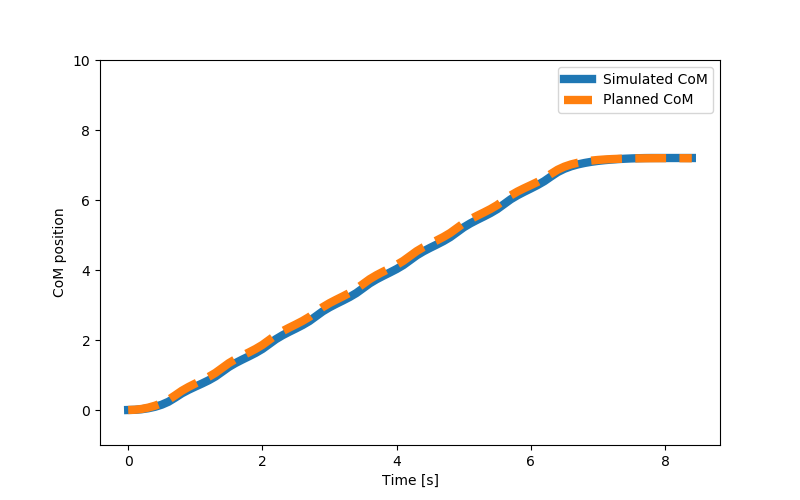

<IPython.core.display.Javascript object>


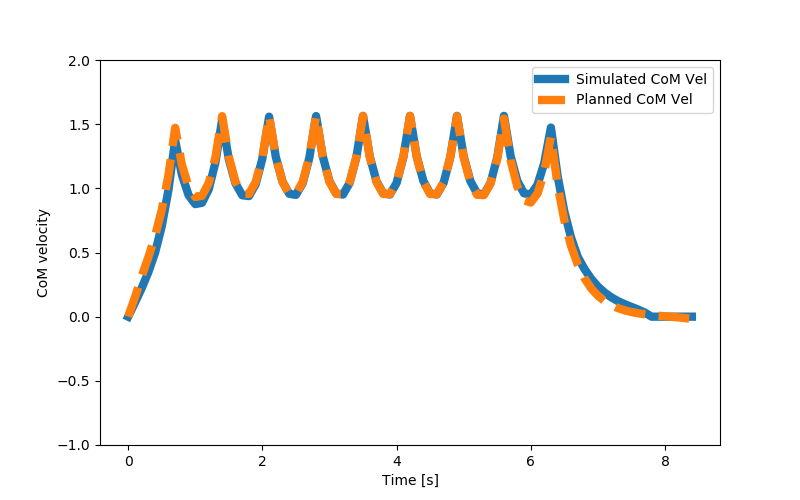

<IPython.core.display.Javascript object>


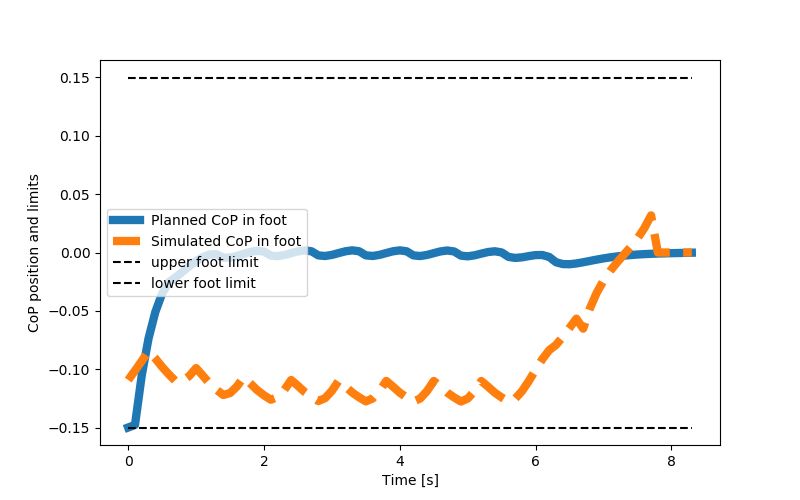

<IPython.core.display.Javascript object>


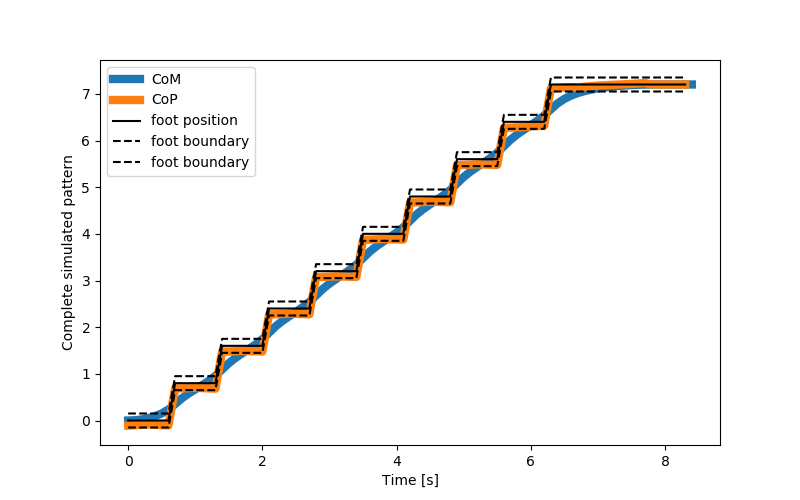

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAZAFtZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADG1liIQAP//+92ifApta
Q3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAADAAB1oWGAKaHP4R4lcQHw3p8gnsmuEhX4031cd/7I
rod6Ryww2Ogq+9e1xtldqQff7T8tEDJB70M96AfOtAd2Gy9DhMHlVY1SVrOLanMctObctagCEbk4
u4BjdBxwTMq8AihBeS6vxvQFWwO1WVYHYrv6ZG86ICsNd+3z648sSeZ6Av9jAxslHynmzh3wCM+v
Sm6W1YdCAsB8d7SVO/+ZQIfQ+4DAXIFjphAZbmOcdwu2wwxf+QclE2IUVk7ICDwpkRF6bTndOjuN
oCA231YWhD30g8xhaz7Ntqp0P2HlvzESp8XJ4XvZo6xzklPKU6/qcolaId6U7M3w4ae8+Ap0ciVc
cDhgQjJJ4L12FTKb2WB+yYFr/c9GtIlK3M7PhhtNis0TBxCbQzKN93kdWOY/KTcdkRnGGgWB0awQ
EK6Oq19TMBzlb51Tn3yzoyBgjtI9CyY9xqSo5U37qw43NCV0WwRd3zNDW0uQ3RJXbRmha9Q94Dxv
ZpTEsWW6Nkzf7Ec77HPhqt0atfHn/8h2cuVtrBtwR9S05trhMjoqRYs2iGH1nY+eW6qbmQVRQbS2
I7vnG+oMFWc6xKqWV4czcLnke3Tv9L3XpVq4nvFwl3TaNPDJLt/BKDqb/07D85OSwKrZ7SbAj3ci
kLK8f4Er8ibrG0DcwUCOU5zqoMRgByH3qe1foer80aGWB0djSgf/U//a07ZivcBRJEYC7yfr7ruN
xrQFxaHhsjhTK6UF/r4GhIFdIkuJX1p+EWc+jyaKOQ6koz7Vdlp8veljjfEKpwCPjvEDQY6llpf5
b4Q2QV43hU8EvLHx6I4ldm1Lh2qCc2klETq55TJ16dWTr28/03DhdxMOu/XPnrUCMdoN0EZJ0GhN
Q1nkY63+RFmQDGL3OFv/y+qwczzAgAABnEHjjM5Qxcu4R4KqYEtYp5bvR4y9JwWNm28FJlpvNqnD
LShhfB0uPgxl6gFjDcpROjnMDUDviQ6cBu3g7Yn/vqrtaztE/4PP5vW+cQ66thTyo9bwXQNxu/Br
UQ5omGvVeY00getzhT7WFIAdIMe/Liq+i0Cys12XlND2giwxtpgIlmPk4yMSIr+gqsRAhQeNQ48q
pcB0B/FXbtKVpJXw9LERDFoy47TgzO2uISFnCzrzmKWFbfNwffgd3yeSR7N8QEBsdy9hdLxBbRb1
VGag8x/OGPo0e7vlevmwNqUohZFuXNsgi0LAQUTEtM2NVwK+neMcrSzLxKpIsE/2ROzcf0nXPru2
KR9JdcKP2mCAI3XkQOnTSq3+I05mTsn6ctk2GRD8xo+OXMEBrA/+hsFiGRP8mC99pMi4Yi/MuWHQ
0TJHkOHXHZtf/DujNueKDGXgFzYYn5fBDLrOu3YeSu+KZexvRBqG10ncTRalESf47YW/nXIEgXt/
cbkRCmtaiyoqjX8o2yLiC2KoUsycQbfZlbiZH4zLCtrmUCu8hRqm9dlzAN4vTdbts4BqiLM7SbGd
Vy4tmVcXk6GsZbcleL6j6u3xbTkfdiEPXAWCXSgFKqQ19G77A8VAmZVsA4RGiFpHjSkbtzMEbKzJ
u2L3B9tarwkhuIIz6a+kI/3cDK+DFms3nzHlmBCXteqss6ZSOrvltbeZbuBisqr1oUD+UJNNRPxv
6OBF8mooFRSkPMtcFh0XhmUjnJzOKeqHuktkPvlJ/Zh+Yq0sbrcLpRG0nO97eLMseqp0ODUU9FZG
hRr4C/uvyvBVFlAe8UrUCScmRCoB/cnB/ZqoP/eJ0w4ikc6rqRaNLo/xehvK7F/60HOOfLyl4NSh
8FAMymHRqYTDmjOZKIL6EGoUYZs90/9RXtQhH02LcDj7jX0R99c4QCY/zmlqS/GyrtlYeatSMQxH
Yutiu3kHC7I/xY/Bjq3vGOzPnPQ+tZ8i4eDgJS8fFfy0t1KtJ/rC5fYE6h/zaAtkTPlZiu0ZI3ud
q96swlh13LOJX1FTSu0MVcW9xkU/ftufwb8Ks74dmXLUlTmYe2pPmiJ3sUd+wuyoFmSf9JZ5wDv8
W3zhqRBxxTgAPO9DXgXFGyO2bpVhMKntvbi9M6Umpqayr/633gTE0b0qtIiX04J96ifPOLM14hqM
zYmZsOltevIH+r27ms3cEBqFQE64KFfyJpue8TYcQM1+Ku/eAW03738CnDSRKj7sUNPk4SW86ico
wrjcqpXQGSipuLpAkbhtFeLcpXMhu5qWZkxT0HuPOTR1XITiF9kbIfrbK4TUXh1uc8bytz/CuKKV
RUQoLZljSiruP30dA4LG/w431Hd/nU3e0gj6uKzpq1K5c+tZlj+bFIn2TpXdmACebzdbkJJL0IBn
em3UTGcU8h24MR6Ko040n33nPb9rog+7lq6vXrRSqhj0ZFur/h2qAbaPl6gJnZi+okQeurxIZMYN
8RXlVY/e1wuLMveg4O8MxziQ40Bkq7ZxTPgIbyEiUyBsr/JkBHZ4VxcqJWbpWJluJluzGnhK08Cj
b6rBMF20lQMa3pZtn2OwAsIKm99a20IulbsAJlEVcKePRDphTJAAAAMAiwV0ZYzwa0NHC20kCRR/
1/JbdNPTjU81NT7Ycb8YkMI4v15SGAG9JJ8O7mrvi2k8rw91Wz3pfEw0+Vtu+Ry5GU7k4P7+zFfw
gfUX3iOKhZ4GSJy9/c0+SJ652n039h0k/NPubd3nIh8Ao5ITdNh6KiDWu2KeUpbHJ7RfB4XkubJy
8yJuRq0+SbgULlQm0kxp3EkV1E8Nz0lIyUZClUrX0u6JwtKVe/+mRtsuwFGv8/isMTCciOnlKfOw
B2NiWr0Hv5J2Ml2tRRugQVCn6PRea+EcA1Zi0NuCN/6fzbGBUCCDM8Wxs6CCCTpDUFZHXu6z1N9x
+oesYCS6pCGW9HmHnisM0

In [22]:
#Part E
#Changing Cost
#Named the model walking_modelE
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(round(step_time / walking_model.dt))

#states for model predicitive control
x_model = np.empty([2, horizon_length+1])
x_model[:,0] = x0

#controls for model predictive control
u_model=np.empty([1,horizon_length])
# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []
###########3
################
#################3
########################Changing the terminal cost
# we will fill the lists for each time step
for i in range(horizon_length):
    if i<horizon_length- iterations_per_step:
        Q_nominal = np.eye(2)
    else:
        Q_nominal = np.eye(2)* 1e9 #########changed the terminal cost 
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))
#######
##########
##############
# Changing horizon Length
# Model Predicitive Control
X = 11


for i in range(horizon_length):
    if (horizon_length-i<X):
        Qnew = Q[i:]
        qnew = q[i:]
        Rnew = R[i:]
        rnew = r[i:]
        G_bounds_new = G_bounds[i:]
        h_bounds_new = h_bounds[i:]
        foot_position_new = foot_position[i:]
        horizon_length_new = horizon_length - i
        x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Qnew,
                                             qnew,Rnew,rnew,G_bounds_new, h_bounds_new, horizon_length_new, x0)
        feedforward_controller = lambda x,i: u_plan[0,i]
        x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length_new, foot_position_new, noise=True)
        x0 = x_real[:,1]
        u_model[:,i] = u_real[:,0]
        x_model[:,i+1] = x0
    else:
        Qnew = Q[i:X+i]
        qnew = q[i:X+i]
        Rnew = R[i:X+i]
        rnew = r[i:X+i]
        G_bounds_new = G_bounds[i:X+i]
        h_bounds_new = h_bounds[i:X+i]
        foot_position_new = foot_position[i:X+i]
        horizon_length_new = X
        
        x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Qnew,
                                             qnew,Rnew,rnew,G_bounds_new, h_bounds_new, horizon_length_new, x0)        
        feedforward_controller = lambda x,i: u_plan[0,i]
        x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length_new, foot_position_new, noise=True)
        x0 = x_real[:,1]
        u_model[:,i] = u_real[:,0]
        x_model[:,i+1] = x0
plot_results(x_model, u_model, x_plan0, u_plan0)
animate_walker(x_model, u_model, foot_position)